# Analysis and Classification of Attacks using Realistic Botnet Dataset

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Helper function to visualize classification reports
def visualize_classification_report(y_true, y_pred, title="Classification Report"):
    # Get classification report as text and as a dictionary
    report = classification_report(y_true, y_pred, output_dict=True)
    report_text = classification_report(y_true, y_pred)
    print(report_text)
    
    # Create a dataframe from the classification report dictionary
    report_df = pd.DataFrame(report).T
    report_df = report_df.drop('support', axis=1)  # Remove the support column for better visualization
    report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')  # Drop summary rows
    
    # Visualize classification report as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df, annot=True, fmt='.2f', cmap='Blues_r')
    plt.title(f"{title} - Classification Report Metrics")
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(set(y_true)), 
                yticklabels=sorted(set(y_true)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{title} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [ ]:
# Training Dataset
data = pd.read_csv(r"C:\Users\nihca\OneDrive\Documents\vscode\SRIP_2025\UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
data.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [ ]:
# General Information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934817 entries, 0 to 2934816
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pkSeqID            int64  
 1   proto              object 
 2   saddr              object 
 3   sport              object 
 4   daddr              object 
 5   dport              object 
 6   seq                int64  
 7   stddev             float64
 8   N_IN_Conn_P_SrcIP  int64  
 9   min                float64
 10  state_number       int64  
 11  mean               float64
 12  N_IN_Conn_P_DstIP  int64  
 13  drate              float64
 14  srate              float64
 15  max                float64
 16  attack             int64  
 17  category           object 
 18  subcategory        object 
dtypes: float64(6), int64(6), object(7)
memory usage: 425.4+ MB


## Exploratory Data Analysis

In [ ]:
data.describe()

,pkSeqID,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
count,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06,2.934817e+06
mean,1.834209e+06,1.212973e+05,8.869639e-01,8.254997e+01,1.017208e+00,3.134219e+00,2.230471e+00,9.245766e+01,4.303064e-01,3.128290e+00,3.019269e+00,9.998739e-01
std,1.059058e+06,7.578700e+04,8.036391e-01,2.439019e+01,1.483551e+00,1.187107e+00,1.517766e+00,1.816651e+01,5.623304e+01,7.845494e+02,1.860915e+00,1.122750e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.171090e+05,5.484700e+04,2.999700e-02,6.900000e+01,0.000000e+00,3.000000e+00,1.819340e-01,1.000000e+02,0.000000e+00,1.558450e-01,2.804170e-01,1.000000e+00
50%,1.834316e+06,1.177370e+05,7.925750e-01,1.000000e+02,0.000000e+00,4.000000e+00,2.689973e+00,1.000000e+02,0.000000e+00,2.837800e-01,4.008429e+00,1.000000e+00
75%,2.751250e+06,1.848700e+05,1.745220e+00,1.000000e+02,2.147949e+00,4.000000e+00,3.565061e+00,1.000000e+02,0.000000e+00,4.880000e-01,4.292426e+00,1.000000e+00
max,3.668522e+06,2.622110e+05,2.496763e+00,1.000000e+02,4.980471e+00,1.100000e+01,4.981882e+00,1.000000e+02,5.882353e+04,1.000000e+06,4.999999e+00,1.000000e+00


In [ ]:
data["proto"].value_counts()

proto
udp          1596819
tcp          1330598
icmp            7228
arp              166
ipv6-icmp          6
Name: count, dtype: int64

In [ ]:
data["saddr"].value_counts()

saddr
192.168.100.147              761360
192.168.100.148              738642
192.168.100.150              712260
192.168.100.149              711466
192.168.100.3                  6609
192.168.100.5                  4107
192.168.100.6                   272
192.168.100.7                    34
192.168.100.4                    17
192.168.100.1                    14
192.168.100.27                    9
192.168.100.46                    8
fe80::250:56ff:febe:254           5
192.168.100.55                    3
fe80::250:56ff:febe:89ee          2
fe80::250:56ff:febe:26db          2
fe80::250:56ff:febe:c038          2
fe80::2c6a:ff9b:7e14:166a         2
fe80::c0c0:aa20:45b9:bdd9         2
fe80::250:56ff:febe:e9d9          1
Name: count, dtype: int64

In [ ]:
data["sport"].value_counts()

sport
0x0303    7156
80        3220
1822       878
60541      869
1216       868
          ... 
7813        31
39305       30
18992       30
0x000d      10
0x0011       8
Name: count, Length: 65541, dtype: int64

In [ ]:
data["daddr"].value_counts()

daddr
192.168.100.3      1900562
192.168.100.5       361192
192.168.100.7       332161
192.168.100.6       329679
192.168.100.150       3040
                    ...   
205.251.194.167          1
224.0.0.252              1
216.239.38.10            1
205.251.194.84           1
205.251.198.119          1
Name: count, Length: 81, dtype: int64

In [ ]:
data["dport"].value_counts()

dport
80       2858794
1           5379
3306        3757
53           275
-1           166
          ...   
4468           1
5425           1
6650           1
42305          1
42904          1
Name: count, Length: 6906, dtype: int64

In [ ]:
data["category"].value_counts()

category
DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: count, dtype: int64

In [ ]:
data["attack"].value_counts()

attack
1    2934447
0        370
Name: count, dtype: int64

In [ ]:
data["subcategory"].value_counts()

subcategory
UDP                  1584650
TCP                  1274843
Service_Scan           58626
OS_Fingerprint         14293
HTTP                    1970
Normal                   370
Keylogging                59
Data_Exfiltration          6
Name: count, dtype: int64

### Extracting 10 best features

In [ ]:
ten_best_features = data[['seq','stddev','N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max']]
target_features = data[['attack','category','subcategory']]

## Data Preprocessing

In [ ]:
# Label Encoding the target columns
le = LabelEncoder()
target_features['category'] = le.fit_transform(target_features['category'])
target_features['subcategory'] = le.fit_transform(target_features['subcategory'])

target_features.head()

,attack,category,subcategory
0,1,0,7
1,1,0,6
2,1,0,6
3,1,1,7
4,1,0,7


In [ ]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(ten_best_features,target_features)

In [ ]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Defining the ML Model Classes

In [ ]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)
    
    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])
        
        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])
        
        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])
        
    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)
        
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)
        
        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)
        
        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})

In [ ]:
class NaiveBayes:
    def __init__(self):
        self.nb_attack = GaussianNB()
        self.nb_category = GaussianNB()
        self.nb_subcategory = GaussianNB()
    
    def fit(self,X_train,y_train):
        self.nb_attack.fit(X_train,y_train['attack'])
        
        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.nb_category.fit(features_category,y_train['category'])
        
        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.nb_subcategory.fit(features_subcategory,y_train['subcategory'])
        
    def predict(self,X_test):
        predict_attack = self.nb_attack.predict(X_test)
        
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.nb_category.predict(test_category)
        
        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.nb_subcategory.predict(test_subcategory)
        
        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})

In [ ]:
class DecisionTree:
    def __init__(self,criterion,max_depth=5):
        self.dtree_attack = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
        self.dtree_category = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
        self.dtree_subcategory = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
    
    def fit(self,X_train,y_train):
        self.dtree_attack.fit(X_train,y_train['attack'])
        
        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.dtree_category.fit(features_category,y_train['category'])
        
        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.dtree_subcategory.fit(features_subcategory,y_train['subcategory'])
        
    def predict(self,X_test):
        predict_attack = self.dtree_attack.predict(X_test)
        
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.dtree_category.predict(test_category)
        
        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.dtree_subcategory.predict(test_subcategory)
        
        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})

In [ ]:
class GradientBoost:
    def __init__(self):
        self.xgb_attack = XGBClassifier()
        self.xgb_category = XGBClassifier()
        self.xgb_subcategory = XGBClassifier()
    
    def fit(self,X_train,y_train):
        self.xgb_attack.fit(X_train,y_train['attack'])
        
        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.xgb_category.fit(features_category,y_train['category'])
        
        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.xgb_subcategory.fit(features_subcategory,y_train['subcategory'])
        
    def predict(self,X_test):
        predict_attack = self.xgb_attack.predict(X_test)
        
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.xgb_category.predict(test_category)
        
        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.xgb_subcategory.predict(test_subcategory)
        
        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})

### Validation of ML Models on Training Dataset

**Random Forest**

In [ ]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)

In [ ]:
visualize_classification_report(y_test['attack'], predictions_rfc['attack'], title="Random Forest: Attack")

[[     6     74]
 [     0 733625]]
              precision    recall  f1-score   support

           0       1.00      0.07      0.14        80
           1       1.00      1.00      1.00    733625

    accuracy                           1.00    733705
   macro avg       1.00      0.54      0.57    733705
weighted avg       1.00      1.00      1.00    733705



In [ ]:
visualize_classification_report(y_test['category'], predictions_rfc['category'], title="Random Forest: Category")

[[367219  18164      0      0      0]
 [ 35880 294073      0      3      0]
 [     0     51      0     29      0]
 [ 10221   2299      0   5747      0]
 [     0      6      0     13      0]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    385383
           1       0.93      0.89      0.91    329956
           2       0.00      0.00      0.00        80
           3       0.99      0.31      0.48     18267
           4       0.00      0.00      0.00        19

    accuracy                           0.91    733705
   macro avg       0.56      0.43      0.46    733705
weighted avg       0.91      0.91      0.91    733705



In [ ]:
visualize_classification_report(y_test['subcategory'], predictions_rfc['subcategory'], title="Random Forest: Subcategory")

[[     0      0      0      0      0      0      0      1]
 [     0      0      0      0      0      3    508      0]
 [     0      0      0      0      0     13      2      3]
 [     0      0      0      0      0     30     48      2]
 [     0      0      0      0      0    159   3516      9]
 [     0      0      0      0      0   6734   7843      6]
 [     0      0      0      0      0      0 318273    229]
 [     0      0      0      0      0      0     14 396312]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00       511
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00      3684
           5       0.97      0.46      0.63     14583
           6       0.96      1.00      0.98    318502
           7       1.00      1.00      1.00    396326

    accuracy                           

In [ ]:
rf.rfc_attack.score(X_test,y_test['attack'])

0.999899142025746

In [ ]:
rf.rfc_category.score(np.concatenate((X_test,np.array(predictions_rfc['attack']).reshape(-1,1)),axis=1),y_test['category'])

0.9091378687619683

In [ ]:
rf.rfc_subcategory.score(np.concatenate((X_test,np.array(predictions_rfc['attack']).reshape(-1,1),
                                    np.array(predictions_rfc['category']).reshape(-1,1)),axis=1),y_test['subcategory'])

0.9831185558228444

**Naive Bayes**

In [ ]:
nb = NaiveBayes()
nb.fit(X_train,y_train)

predictions_nb = nb.predict(X_test)

In [ ]:
visualize_classification_report(y_test['attack'], predictions_nb['attack'], title="Naive Bayes: Attack")

[[    72      8]
 [  2725 730900]]
              precision    recall  f1-score   support

           0       0.03      0.90      0.05        80
           1       1.00      1.00      1.00    733625

    accuracy                           1.00    733705
   macro avg       0.51      0.95      0.52    733705
weighted avg       1.00      1.00      1.00    733705



In [ ]:
visualize_classification_report(y_test['category'], predictions_nb['category'], title="Naive Bayes: Category")

[[368988  16214     28    153      0]
 [183561 145087    642    666      0]
 [     0      4     72      4      0]
 [ 10795   1180   2050   4242      0]
 [     0      0      5      0     14]]
              precision    recall  f1-score   support

           0       0.65      0.96      0.78    385383
           1       0.89      0.44      0.59    329956
           2       0.03      0.90      0.05        80
           3       0.84      0.23      0.36     18267
           4       1.00      0.74      0.85        19

    accuracy                           0.71    733705
   macro avg       0.68      0.65      0.53    733705
weighted avg       0.77      0.71      0.68    733705



In [ ]:
visualize_classification_report(y_test['subcategory'], predictions_nb['subcategory'], title="Naive Bayes: Subcategory")

[[     0      0      0      1      0      0      0      0]
 [     0    306      0     11      1    173     20      0]
 [     0      0     14      4      0      0      0      0]
 [     0      0      0     72      1      3      4      0]
 [     0    229      0    121      3    154   3177      0]
 [     0    617      0   1929    256   3829   7952      0]
 [     0    912      0    652      3    641 316294      0]
 [     0      0      0      7      1      0     28 396290]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.15      0.60      0.24       511
           2       1.00      0.78      0.88        18
           3       0.03      0.90      0.05        80
           4       0.01      0.00      0.00      3684
           5       0.80      0.26      0.40     14583
           6       0.97      0.99      0.98    318502
           7       1.00      1.00      1.00    396326

    accuracy                           

**Decision Tree (Information Gain)**

In [ ]:
dtree_ig = DecisionTree('entropy')
dtree_ig.fit(X_train,y_train)
predictions_dtree_ig = dtree_ig.predict(X_test)

In [ ]:
visualize_classification_report(y_test['attack'], predictions_dtree_ig['attack'], title="Decision Tree (Information Gain): Attack")

[[    29     51]
 [     1 733624]]
              precision    recall  f1-score   support

           0       0.97      0.36      0.53        80
           1       1.00      1.00      1.00    733625

    accuracy                           1.00    733705
   macro avg       0.98      0.68      0.76    733705
weighted avg       1.00      1.00      1.00    733705



In [ ]:
visualize_classification_report(y_test['category'], predictions_dtree_ig['category'], title="Decision Tree (Information Gain): Category")

[[339160  45680      0    543      0]
 [ 11630 318270      0     56      0]
 [     0     11     25     44      0]
 [   393   7462      1  10411      0]
 [     0      2      0     17      0]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    385383
           1       0.86      0.96      0.91    329956
           2       0.96      0.31      0.47        80
           3       0.94      0.57      0.71     18267
           4       0.00      0.00      0.00        19

    accuracy                           0.91    733705
   macro avg       0.74      0.55      0.60    733705
weighted avg       0.92      0.91      0.91    733705



In [ ]:
visualize_classification_report(y_test['subcategory'], predictions_dtree_ig['subcategory'], title="Decision Tree (Information Gain): Subcategory")

[[     0      0      0      0      1      0      0      0]
 [     0    358      0      0      0     98     54      1]
 [     0      2      0      0      3     13      0      0]
 [     0      0      0     27      4     38      1     10]
 [     0      0      0      2    968    555   2137     22]
 [     0     17      0      0    236   8652   5662     16]
 [     0      2      0      0      0    489 318010      1]
 [     0      0      0     12      0      0      5 396309]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.94      0.70      0.80       511
           2       0.00      0.00      0.00        18
           3       0.66      0.34      0.45        80
           4       0.80      0.26      0.40      3684
           5       0.88      0.59      0.71     14583
           6       0.98      1.00      0.99    318502
           7       1.00      1.00      1.00    396326

    accuracy                           

In [ ]:
dtree_ig.dtree_attack.score(X_test,y_test['attack'])

0.9999291268289027

In [ ]:
dtree_ig.dtree_category.score(np.concatenate((X_test,np.array(predictions_dtree_ig['attack']).reshape(-1,1)),axis=1),y_test['category'])

0.9102650247715363

In [ ]:
dtree_ig.dtree_subcategory.score(np.concatenate((X_test,np.array(predictions_dtree_ig['attack']).reshape(-1,1),
                                        np.array(predictions_dtree_ig['category']).reshape(-1,1)),axis=1),y_test['subcategory'])

0.9872142073449138

**Decision Tree (Gini Index)**

In [ ]:
dtree_gini = DecisionTree('gini')
dtree_gini.fit(X_train,y_train)
predictions_dtree_gini = dtree_gini.predict(X_test)

In [ ]:
visualize_classification_report(y_test['attack'], predictions_dtree_gini['attack'], title="Decision Tree (Gini Index): Attack")

[[    28     52]
 [     8 733617]]
              precision    recall  f1-score   support

           0       0.78      0.35      0.48        80
           1       1.00      1.00      1.00    733625

    accuracy                           1.00    733705
   macro avg       0.89      0.67      0.74    733705
weighted avg       1.00      1.00      1.00    733705



In [ ]:
visualize_classification_report(y_test['category'], predictions_dtree_gini['category'], title="Decision Tree (Gini Index): Category")

[[338104  46783      0    496      0]
 [  8538 321408      3      7      0]
 [     0     15     25     40      0]
 [    86   7389      4  10788      0]
 [     0      4      1     14      0]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.92    385383
           1       0.86      0.97      0.91    329956
           2       0.76      0.31      0.44        80
           3       0.95      0.59      0.73     18267
           4       0.00      0.00      0.00        19

    accuracy                           0.91    733705
   macro avg       0.71      0.55      0.60    733705
weighted avg       0.92      0.91      0.91    733705



In [ ]:
visualize_classification_report(y_test['subcategory'], predictions_dtree_gini['subcategory'], title="Decision Tree (Gini Index): Subcategory")

[[     0      0      1      0      0      0      0      0]
 [     0    430      0      0      0      9     72      0]
 [     0      0      3      0      0     15      0      0]
 [     0     11      0      3      4     59      3      0]
 [     0     16      0      0    899    694   2075      0]
 [     0     18      2      0     72   9131   5360      0]
 [     0     78      0      0      0    497 317926      1]
 [     0      0      0      0      0      0      8 396318]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.78      0.84      0.81       511
           2       0.50      0.17      0.25        18
           3       1.00      0.04      0.07        80
           4       0.92      0.24      0.39      3684
           5       0.88      0.63      0.73     14583
           6       0.98      1.00      0.99    318502
           7       1.00      1.00      1.00    396326

    accuracy                           

In [ ]:
dtree_gini.dtree_attack.score(X_test,y_test['attack'])

0.9999182232641184

In [ ]:
dtree_gini.dtree_category.score(np.concatenate((X_test,np.array(predictions_dtree_gini['attack']).reshape(-1,1)),axis=1),y_test['category'])

0.9136165079970833

In [ ]:
dtree_gini.dtree_subcategory.score(np.concatenate((X_test,np.array(predictions_dtree_gini['attack']).reshape(-1,1),
                                        np.array(predictions_dtree_gini['category']).reshape(-1,1)),axis=1),y_test['subcategory'])

0.987740304345752

**Gradient Boost**

In [ ]:
xgb = GradientBoost()
xgb.fit(X_train,y_train)
predictions_xgb = xgb.predict(X_test)

In [ ]:
visualize_classification_report(y_test['attack'], predictions_xgb['attack'], title="Gradient Boost: Attack")

[[    50     30]
 [    45 733580]]
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        80
           1       1.00      1.00      1.00    733625

    accuracy                           1.00    733705
   macro avg       0.76      0.81      0.79    733705
weighted avg       1.00      1.00      1.00    733705



In [ ]:
visualize_classification_report(y_test['category'], predictions_xgb['category'], title="Gradient Boost: Category")

[[385164    211      8      0      0]
 [    31 329922      2      0      1]
 [     0      5     50     25      0]
 [     0      2     31  18234      0]
 [     0      0      1      1     17]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    385383
           1       1.00      1.00      1.00    329956
           2       0.54      0.62      0.58        80
           3       1.00      1.00      1.00     18267
           4       0.94      0.89      0.92        19

    accuracy                           1.00    733705
   macro avg       0.90      0.90      0.90    733705
weighted avg       1.00      1.00      1.00    733705



In [ ]:
visualize_classification_report(y_test['subcategory'], predictions_xgb['subcategory'], title="Gradient Boost: Subcategory")

[[     1      0      0      0      0      0      0      0]
 [     1    506      0      4      0      0      0      0]
 [     0      0     16      1      0      1      0      0]
 [     0      2      0     50      8     17      3      0]
 [     0      0      0      4   3137    542      1      0]
 [     0      0      0     27    311  14245      0      0]
 [     0      0      0      6      0      0 318496      0]
 [     0      0      0      0      0      0      5 396321]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.99      0.99       511
           2       1.00      0.89      0.94        18
           3       0.54      0.62      0.58        80
           4       0.91      0.85      0.88      3684
           5       0.96      0.98      0.97     14583
           6       1.00      1.00      1.00    318502
           7       1.00      1.00      1.00    396326

    accuracy                           

In [ ]:
xgb.xgb_attack.score(X_test,y_test['attack'])

0.999897779080148

In [ ]:
xgb.xgb_category.score(np.concatenate((X_test,np.array(predictions_xgb['attack']).reshape(-1,1)),axis=1),y_test['category'])

0.9995665832998276

In [ ]:
xgb.xgb_subcategory.score(np.concatenate((X_test,np.array(predictions_xgb['attack']).reshape(-1,1),
                                        np.array(predictions_xgb['category']).reshape(-1,1)),axis=1),y_test['subcategory'])

0.9987283717570413

### Test Data

In [ ]:
test_data = pd.read_csv(r"C:\Users\nihca\OneDrive\Documents\vscode\SRIP_2025\UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
test_data.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [ ]:
# Extracting the ten-best features from test set
test_ten_best = test_data[ten_best_features.columns]
test_labels = test_data[['attack','category','subcategory']]
test_ten_best.head()

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max
0,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619
1,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924
2,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205
3,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302
4,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452


**Using complete training data and test data**

In [ ]:
# Standard Scaling
train_data = sc.fit_transform(ten_best_features)
test = sc.transform(test_ten_best)

In [ ]:
ten_best_features = data[['seq','stddev','N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max']]
target_features = data[['attack','category','subcategory']]

In [ ]:
# Label Encoding

target_features['category'] = le.fit_transform(target_features['category'])
test_labels['category'] = le.transform(test_labels['category'])

target_features['subcategory'] = le.fit_transform(target_features['subcategory'])
test_labels['subcategory'] = le.transform(test_labels['subcategory'])

### Training ML Models on Complete Data and Testing on test set

**Random Forest**

In [ ]:
rf_clf = RandomForest(max_depth=5)
rf_clf.fit(train_data,target_features)
predictions_rf = rf_clf.predict(test)

In [ ]:
visualize_classification_report(test_labels['attack'], predictions_rf['attack'], title="Random Forest: Attack (Test Data)")

Random Forest: Attack

[[    131     239]
 [      0 2934447]] 

              precision    recall  f1-score   support

           0       1.00      0.35      0.52       370
           1       1.00      1.00      1.00   2934447

    accuracy                           1.00   2934817
   macro avg       1.00      0.68      0.76   2934817
weighted avg       1.00      1.00      1.00   2934817



In [ ]:
visualize_classification_report(test_labels['category'], predictions_rf['category'], title="Random Forest: Category (Test Data)")

Random Forest: Category

[[1514050   27264       0       1       0]
 [  47126 1273010       0      12       0]
 [      0      79      90     201       0]
 [   2203      85       0   70631       0]
 [      0      15       0      50       0]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98   1541315
           1       0.98      0.96      0.97   1320148
           2       1.00      0.24      0.39       370
           3       1.00      0.97      0.98     72919
           4       0.00      0.00      0.00        65

    accuracy                           0.97   2934817
   macro avg       0.79      0.63      0.66   2934817
weighted avg       0.97      0.97      0.97   2934817



In [ ]:
visualize_classification_report(test_labels['subcategory'], predictions_rf['subcategory'], title="Random Forest: Subcategory (Test Data)")

Random Forest: Subcategory

[[      0       0       0       0       0       2       0       4]
 [      0     512       0       0       0       8    1450       0]
 [      0       0       0       0       0      48       0      11]
 [      0       4       0      85       0     206      66       9]
 [      0       0       0       0       2   13759     528       4]
 [      0       1       0       0       0   56904    1720       1]
 [      0       0       0       0       0       1 1274239     603]
 [      0       0       0       0       0       4      24 1584622]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      0.26      0.41      1970
           2       0.00      0.00      0.00        59
           3       1.00      0.23      0.37       370
           4       1.00      0.00      0.00     14293
           5       0.80      0.97      0.88     58626
           6       1.00      1.00      1.00   1274843
  

**Naive Bayes**

In [ ]:
nb_clf = NaiveBayes()
nb_clf.fit(train_data,target_features)
predictions_nb = nb_clf.predict(test)

In [ ]:
visualize_classification_report(test_labels['attack'], predictions_nb['attack'], title="Naive Bayes: Attack (Test Data)")

Naive Bayes: Attack

[[    336      34]
 [  10990 2923457]]
              precision    recall  f1-score   support

           0       0.03      0.91      0.06       370
           1       1.00      1.00      1.00   2934447

    accuracy                           1.00   2934817
   macro avg       0.51      0.95      0.53   2934817
weighted avg       1.00      1.00      1.00   2934817



In [ ]:
visualize_classification_report(test_labels['category'], predictions_nb['category'], title="Naive Bayes: Category (Test Data)")

Naive Bayes: Category

[[1475076   65621     158     460       0]
 [ 731940  584166    2724    1318       0]
 [      0      24     336      10       0]
 [  43080    6861    8076   14902       0]
 [      0       0      32       0      33]] 

              precision    recall  f1-score   support

           0       0.66      0.96      0.78   1541315
           1       0.89      0.44      0.59   1320148
           2       0.03      0.91      0.06       370
           3       0.89      0.20      0.33     72919
           4       1.00      0.51      0.67        65

    accuracy                           0.71   2934817
   macro avg       0.69      0.60      0.49   2934817
weighted avg       0.77      0.71      0.68   2934817



In [ ]:
visualize_classification_report(test_labels['subcategory'], predictions_nb['subcategory'], title="Naive Bayes: Subcategory (Test Data)")

Naive Bayes: Subcategory

[[      1       0       0       5       0       0       0       0]
 [      0    1294       0      33      12     578      53       0]
 [      1       0      31      27       0       0       0       0]
 [      0       1       0     336       6       4      23       0]
 [      0     848       0     449       2     548   12446       0]
 [      0    2231       0    7627    2415   11937   34416       0]
 [      0    3349       0    2818      24    1162 1267490       0]
 [      0       0       0      31       2       0      88 1584529]]
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.17      0.66      0.27      1970
           2       1.00      0.53      0.69        59
           3       0.03      0.91      0.06       370
           4       0.00      0.00      0.00     14293
           5       0.84      0.20      0.33     58626
           6       0.96      0.99      0.98   1274843
    

**Decision Tree (Information Gain)**

In [ ]:
dtree_ig_clf = DecisionTree('entropy')
dtree_ig_clf.fit(train_data,target_features)
predictions_ig = dtree_ig_clf.predict(test)

In [ ]:
visualize_classification_report(test_labels['attack'], predictions_ig['attack'], title="Decision Tree (Information Gain): Attack (Test Data)")

Decision Tree (Information Gain): Attack

[[    147     223]
 [      9 2934438]] 

              precision    recall  f1-score   support

           0       0.94      0.40      0.56       370
           1       1.00      1.00      1.00   2934447

    accuracy                           1.00   2934817
   macro avg       0.97      0.70      0.78   2934817
weighted avg       1.00      1.00      1.00   2934817



In [ ]:
visualize_classification_report(test_labels['category'], predictions_ig['category'], title="Decision Tree (Information Gain): Category (Test Data)")

Decision Tree (Information Gain): Category

[[1356070  183062       0    2183       0]
 [  46156 1273806       2     184       0]
 [     25      56     127     162       0]
 [   1487   29997       5   41430       0]
 [      0       5       1      59       0]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92   1541315
           1       0.86      0.96      0.91   1320148
           2       0.94      0.34      0.50       370
           3       0.94      0.57      0.71     72919
           4       0.00      0.00      0.00        65

    accuracy                           0.91   2934817
   macro avg       0.74      0.55      0.61   2934817
weighted avg       0.92      0.91      0.91   2934817



In [ ]:
visualize_classification_report(test_labels['subcategory'], predictions_ig['subcategory'], title="Decision Tree (Information Gain): Subcategory (Test Data)")

Decision Tree (Information Gain): Subcategory

[[      0       0       4       1       0       1       0       0]
 [      0    1465       0       2       0     374     127       2]
 [      0       5      11       0       0      43       0       0]
 [      0       0       0     135      29     125      33      48]
 [      0       0       0       7    3601    2244    8361      80]
 [      0      68       1       0     950   34643   22912      52]
 [      0      67       0       0       1    1937 1272832       6]
 [      0       0       0      54       1       0      11 1584584]] 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.91      0.74      0.82      1970
           2       0.69      0.19      0.29        59
           3       0.68      0.36      0.47       370
           4       0.79      0.25      0.38     14293
           5       0.88      0.59      0.71     58626
           6       0.98      1.00  

**Decision Tree (Gini Index)**

In [ ]:
dtree_gi_clf = DecisionTree('gini')
dtree_gi_clf.fit(train_data,target_features)
predictions_gi = dtree_gi_clf.predict(test)

In [ ]:
visualize_classification_report(test_labels['attack'], predictions_gi['attack'], title="Decision Tree (Gini Index): Attack (Test Data)")

Decision Tree (Gini Index): Attack

[[    154     216]
 [     14 2934433]] 

              precision    recall  f1-score   support

           0       0.92      0.42      0.57       370
           1       1.00      1.00      1.00   2934447

    accuracy                           1.00   2934817
   macro avg       0.96      0.71      0.79   2934817
weighted avg       1.00      1.00      1.00   2934817



Decision Tree (Gini Index): Category



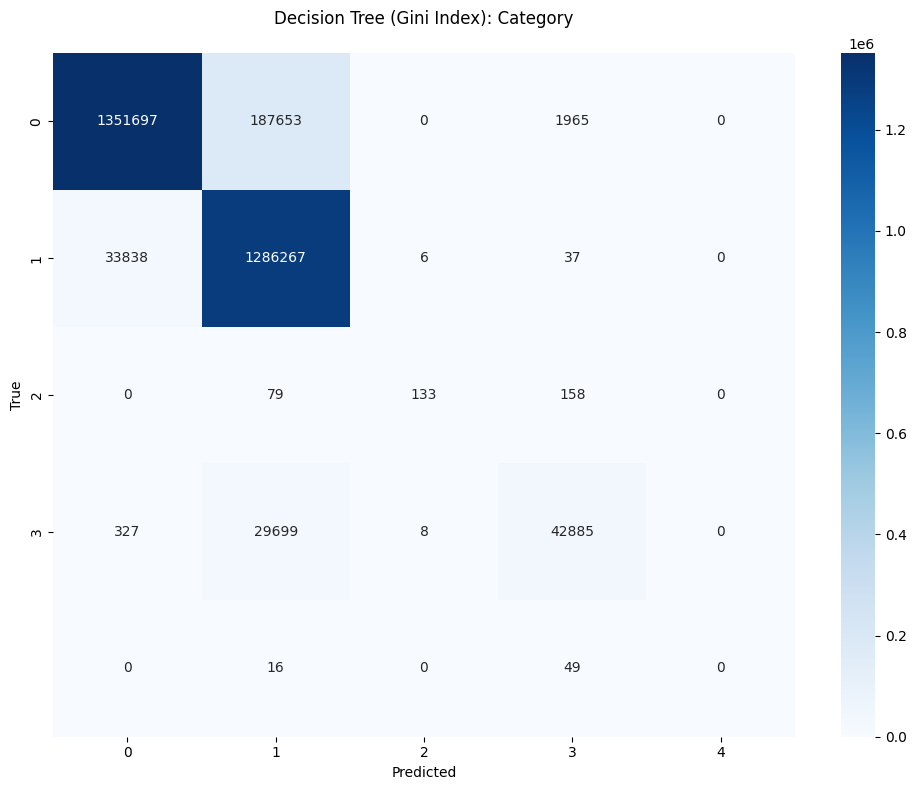

              precision    recall  f1-score   support

           0       0.98      0.88      0.92   1541315
           1       0.86      0.97      0.91   1320148
           2       0.90      0.36      0.51       370
           3       0.95      0.59      0.73     72919
           4       0.00      0.00      0.00        65

    accuracy                           0.91   2934817
   macro avg       0.74      0.56      0.62   2934817
weighted avg       0.92      0.91      0.91   2934817



In [ ]:
visualize_classification_report(test_labels['category'], predictions_gi['category'], title="Decision Tree (Gini Index): Category (Test Data)")

In [ ]:
visualize_classification_report(test_labels['subcategory'], predictions_gi['subcategory'], title="Decision Tree (Gini Index): Subcategory (Test Data)")

Decision Tree (Gini Index): Subcategory

[[      0       0       4       0       0       1       1       0]
 [      0    1642       0       0       0      41     287       0]
 [      0       0      11       0       0      48       0       0]
 [      0       4       0      24      35     240      62       5]
 [      0       0       0       4    3276    2809    8204       0]
 [      0      16       8       1     277   36532   21792       0]
 [      0     261       0       0       1    1965 1272613       3]
 [      0       1       0       0       1       0      22 1584626]] 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.85      0.83      0.84      1970
           2       0.48      0.19      0.27        59
           3       0.83      0.06      0.12       370
           4       0.91      0.23      0.37     14293
           5       0.88      0.62      0.73     58626
           6       0.98      1.00      0.

**Gradient Boost**

In [ ]:
xgb_clf = GradientBoost()
xgb_clf.fit(train_data,target_features)
predictions_gb = xgb_clf.predict(test)

In [ ]:
visualize_classification_report(test_labels['attack'], predictions_gb['attack'], title="Gradient Boost: Attack (Test Data)")

Gradient Boost: Attack

[[     69     301]
 [    335 2934112]] 

              precision    recall  f1-score   support

           0       0.17      0.19      0.18       370
           1       1.00      1.00      1.00   2934447

    accuracy                           1.00   2934817
   macro avg       0.59      0.59      0.59   2934817
weighted avg       1.00      1.00      1.00   2934817



In [ ]:
visualize_classification_report(test_labels['category'], predictions_gb['category'], title="Gradient Boost: Category (Test Data)")

Gradient Boost: Category

[[1540383     911      21       0       0]
 [     54 1319933     161       0       0]
 [      1      99      69     199       2]
 [      0       1      75   72843       0]
 [      0       0      18       1      46]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1541315
           1       1.00      1.00      1.00   1320148
           2       0.20      0.19      0.19       370
           3       1.00      1.00      1.00     72919
           4       0.96      0.71      0.81        65

    accuracy                           1.00   2934817
   macro avg       0.83      0.78      0.80   2934817
weighted avg       1.00      1.00      1.00   2934817



In [ ]:
visualize_classification_report(test_labels['subcategory'], predictions_gb['subcategory'], title="Gradient Boost: Subcategory (Test Data)")

Gradient Boost: Subcategory

[[      6       0       0       0       0       0       0       0]
 [      0    1968       0       2       0       0       0       0]
 [      0       0      40      18       0       1       0       0]
 [      1      17       1      69      75     145      39      23]
 [      0       0       0      10   12176    2106       1       0]
 [      0       0       0      65    1257   57304       0       0]
 [      0       0       0     125       0       0 1274718       0]
 [      0       0       0       2       0       0       1 1584647]] 

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.99      1.00      1.00      1970
           2       0.98      0.68      0.80        59
           3       0.24      0.19      0.21       370
           4       0.90      0.85      0.88     14293
           5       0.96      0.98      0.97     58626
           6       1.00      1.00      1.00   1274843